In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sympy import *
import math 
from datetime import datetime
from scipy.special import gamma, factorial
import scipy.special as sc

In [2]:
#定义变量 
thermal_power_station_strategy=np.zeros(shape=(4,1000)) 
wind_power_station_strategy=np.zeros(shape=(2,1000))
c_wind_speed= np.loadtxt("./data/c_wind_speed_uniform_distribution_(3,25).txt")      
kappa_wind_speed= np.loadtxt("./data/kappa_wind_speed_uniform_distribution_(2,3).txt")  
d_power_demand=np.loadtxt("./data/d_power_demand_normal_distribution_(70,5).txt") #时变的需求侧用电需求  阶梯式变化 
thermal_power_station_dual_variable=np.zeros(shape=(4,1000))
wind_power_station_dual_variable=np.zeros(shape=(2,1000))#两个风力发电站中有一个是受到拜占庭攻击的 假设第二个风力发电站是受到攻击的
E=np.loadtxt("6_Network_Topology_Double_Random_Adjacency_Matrix.txt")
thermal_power_station_cost=np.zeros(shape=(1,1000)) #火力发电成本
wind_power_station_cost=np.zeros(shape=(1,1000)) #风力发电成本
sum_cost=np.zeros(shape=(1,1000)) #总发电成本
#thermal_power_station_eta=[0.0375,0.0375,0.0625,0.035]
thermal_power_station_eta=[0.0675,0.0675,0.0925,0.0625]
thermal_power_station_zeta=[2,1.75,1,3]
thermal_power_station_xi=[0,0,0,0]
thermal_power_station_P_min=[50,20,15,10]
thermal_power_station_P_max=[200,120,80,100]
#wind_power_station_varphi=[3]
wind_power_station_varphi=[1]
wind_power_station_v_in=[3]
wind_power_station_v_out=[25]
wind_power_station_v_r=[13]
wind_power_station_sigma_ue=[5]
wind_power_station_sigma_oe=[30]
wind_power_station_P_r=[160]
wind_power_station_P_min=[0]
wind_power_station_P_max=[160]
sum_thermal_wind_power_station_strategy=np.zeros(shape=(1,1000))
step_size_primal=1
step_size_dual=3
regularization_parameter=0.001
large_Gaussian_Byzantine_attack=np.loadtxt("./data/large_Gaussian_Byzantine_attack_(-10,5).txt")

In [3]:
#火力，风力发电策略初始化
thermal_power_station_strategy[0][0]=70
thermal_power_station_strategy[1][0]=70
thermal_power_station_strategy[2][0]=70
thermal_power_station_strategy[3][0]=70
wind_power_station_strategy[0][0]=70
wind_power_station_strategy[1][0]=0
#初始总发电策略
sum_thermal_wind_power_station_strategy[0][0]=350
#初始化受到攻击的风力发电站的对偶变量
wind_power_station_dual_variable[1][0]=large_Gaussian_Byzantine_attack[0]

#火力，风力发电对偶初始化
thermal_power_station_dual_variable[0][0]=-70
thermal_power_station_dual_variable[1][0]=-70
thermal_power_station_dual_variable[2][0]=-70
thermal_power_station_dual_variable[3][0]=-70
wind_power_station_dual_variable[0][0]=-70

#火力，风力发电对偶初始化
thermal_power_station_dual_variable[0][0]=0
thermal_power_station_dual_variable[1][0]=0
thermal_power_station_dual_variable[2][0]=0
thermal_power_station_dual_variable[3][0]=0
wind_power_station_dual_variable[0][0]=0

#安全发电站的初始总发电成本
#火力发电成本
for i in range(0,4):
    thermal_power_station_cost[0][0]=thermal_power_station_cost[0][0]+thermal_power_station_eta[i]*thermal_power_station_strategy[i][0]*thermal_power_station_strategy[i][0]+thermal_power_station_zeta[i]*thermal_power_station_strategy[i][0]
#风力发电成本
for i in range(0,1):
    wind_power_station_cost[0][0]=wind_power_station_cost[0][0]+wind_power_station_varphi[i]*wind_power_station_strategy[i][0]+wind_power_station_sigma_ue[i]*((wind_power_station_P_r[i]-wind_power_station_strategy[i][0])*(math.exp(-(math.pow(wind_power_station_v_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))-math.exp(-(math.pow(wind_power_station_v_out[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0]))))+(wind_power_station_P_r[i]*wind_power_station_v_in[i]/(wind_power_station_v_r[i]-wind_power_station_v_in[i])+wind_power_station_strategy[i][0])*(math.exp(-(math.pow(wind_power_station_v_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))-math.exp(-(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][0])/wind_power_station_P_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0]))))+(wind_power_station_P_r[i]*c_wind_speed[0]/(wind_power_station_v_r[i]-wind_power_station_v_in[i]))*(sc.gammaincc(1+1/kappa_wind_speed[0],(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][0])/wind_power_station_P_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))*sc.gamma(1+1/kappa_wind_speed[0])-sc.gammaincc(1+1/kappa_wind_speed[0],math.pow(wind_power_station_v_r[i]/c_wind_speed[0],kappa_wind_speed[0]))*sc.gamma(1+1/kappa_wind_speed[0])))+wind_power_station_sigma_oe[i]*((wind_power_station_strategy[i][0])*(1-math.exp(-(math.pow(wind_power_station_v_in[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))+math.exp(-(math.pow(wind_power_station_v_out[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0]))))+(wind_power_station_P_r[i]*wind_power_station_v_in[i]/(wind_power_station_v_r[i]-wind_power_station_v_in[i])+wind_power_station_strategy[i][0])*(math.exp(-(math.pow(wind_power_station_v_in[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))-math.exp(-(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][0])/wind_power_station_P_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0]))))+(wind_power_station_P_r[i]*c_wind_speed[0]/(wind_power_station_v_r[i]-wind_power_station_v_in[i]))*(sc.gammaincc(1+1/kappa_wind_speed[0],(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][0])/wind_power_station_P_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))*sc.gamma(1+1/kappa_wind_speed[0])-sc.gammaincc(1+1/kappa_wind_speed[0],math.pow(wind_power_station_v_in[i]/c_wind_speed[0],kappa_wind_speed[0]))*sc.gamma(1+1/kappa_wind_speed[0])))
#发电总成本
sum_cost[0][0]=thermal_power_station_cost[0][0]+wind_power_station_cost[0][0]

#计算每个发电站的邻居发电站
neighbor_robust1_help=[]
for i in range (0,6):
    for j in range (0,6):
        if E[i][j]!=0:
            neighbor_robust1_help.append(j)
        elif E[i][j]==0:
            neighbor_robust1_help.append(99)
neighbor_robust1=np.array(neighbor_robust1_help).reshape(6,6)

#计算安全的发电站的拜占庭邻居用户数量
q_robust1=[]
for i in range(0,6):
    q_robust1_help=0
    for j in range(0,6):
        if neighbor_robust1[i][j]==5:
            q_robust1_help=q_robust1_help+1
    q_robust1.append(q_robust1_help)

In [4]:
def IOS_Byzantine_attack_decentralized_economic_dispatch(thermal_power_station_strategy,wind_power_station_strategy,c_wind_speed,kappa_wind_speed,d_power_demand,thermal_power_station_dual_variable,wind_power_station_dual_variable,E,thermal_power_station_cost,wind_power_station_cost,thermal_power_station_eta,thermal_power_station_zeta,thermal_power_station_P_min,thermal_power_station_P_max,wind_power_station_varphi,wind_power_station_sigma_ue,wind_power_station_sigma_oe,wind_power_station_P_min,wind_power_station_P_max,sum_thermal_wind_power_station_strategy,step_size_primal,step_size_dual):
    #显示初始化的数据
    #输出初始状态的原变量和对偶变量
    print("***************************attack_free_online_decentralized_economic_dispatch*****************************")
    print("相关变量初始值为：")
    for i in range (0,4):
        print("第",(i+1),"个火力发电站的初始计划发电量为:",thermal_power_station_strategy[i][0])
    for i in range (0,2):
        print("第",(i+5),"个风力发电站的初始计划发电量为:",wind_power_station_strategy[i][0])
    print("****************************************************************************")
    for i in range (0,4):
        print("第",(i+1),"个火力发电站的初始对偶变量为:",thermal_power_station_dual_variable[i][0])
    for i in range (0,1):
        print("第",(i+5),"个风力发电站的初始对偶变量为:",wind_power_station_dual_variable[i][0])
    print("****************************************************************************")
    print("第",(6),"个受到Byzantin攻击的风力发电站的初始对偶变量为:",wind_power_station_dual_variable[1][0])
    print("****************************************************************************")
    print("安全发电站的初始总发电量:",sum_thermal_wind_power_station_strategy[0][0])
    print("*************************")
    print("需求侧平均用电需求:",d_power_demand[0])
    print("****************************************************************************")
    print("风速分布参数c:",c_wind_speed[0])
    print("****************************************************************************")
    print("风速分布参数kappa:",kappa_wind_speed[0])
    print("****************************************************************************")
    print("安全发电站的总发电成本：", sum_cost[0][0])
    print("****************************************************************************")
    print("原变量迭代步长为:",step_size_primal)
    print("*****************************************************************************")
    print("对偶变量迭代步长为:",step_size_dual)
    print("*****************************************************************************")
    
    #开始迭代
    for k in range(1,1000):
        #发电站更新计划发电量和对偶变量
        #对偶变量 先做梯度上升 再做聚合
        #安全发电站的梯度上升
        dual_variable_intermediate=[] #存放当前迭代中6个用户对对偶变量做完梯度下降后得到的中间值
        for i in range(0,4):
            dual_variable_intermediate.append(thermal_power_station_dual_variable[i][k-1]+step_size_dual*((1/6)*thermal_power_station_strategy[i][k-1]-(1/6)*d_power_demand[k-1]-regularization_parameter*thermal_power_station_dual_variable[i][k-1]))
        for j in range(0,1):
            dual_variable_intermediate.append(wind_power_station_dual_variable[j][k-1]+step_size_dual*((1/6)*wind_power_station_strategy[j][k-1]-(1/6)*d_power_demand[k-1]-regularization_parameter*wind_power_station_dual_variable[j][k-1]))
        #受到攻击的风力发电站的对偶值
        dual_variable_intermediate.append(wind_power_station_dual_variable[1][k-1])
        
        #IOS鲁棒聚合+adaptive clipping 安全的火力发电站的对偶更新
        #在做鲁棒聚合前 对收集到的信息进行adaptive clipping的剪裁操作
        for i in range (0,4):
            u_neighbor_help_robust1=neighbor_robust1[i].tolist()#将用户i的邻居序号存在辅助变量u中
            if i==0 or i==3:
                u_neighbor_help_robust1 = list(set(u_neighbor_help_robust1))
                u_neighbor_help_robust1.remove(99)
            if int(q_robust1[i])==1: #只有具有拜占庭邻居的用户才需要先进行adaptive clipping和后续的IOS聚合操作
                #先进行adaptive clipping
                dual_variable_intermediate_auxiliary=[]
                #注意必须以这样的方式赋值 不能直接写dual_variable_intermediate_auxiliary=dual_variable_intermediate
                #不然在修改变量dual_variable_intermediate_auxiliary的同时也会对dual_variable_intermediate进行修改
                for j in range(len(dual_variable_intermediate)): 
                    dual_variable_intermediate_auxiliary.append(dual_variable_intermediate[j])
                dual_variable_receive=[]
                clipping_C=0
                for j in range(0, len(u_neighbor_help_robust1)):
                    dual_variable_receive.append(dual_variable_intermediate_auxiliary[u_neighbor_help_robust1[j]])
                dual_variable_receive.sort()
                clipping_C=-dual_variable_receive[1] #确定clpping的阈值
                #接下来对大于clipping_C的值进行clipping
                for j in range(0, len(u_neighbor_help_robust1)):
                    if -dual_variable_intermediate_auxiliary[u_neighbor_help_robust1[j]]>clipping_C:
                        dual_variable_intermediate_auxiliary[u_neighbor_help_robust1[j]]=-clipping_C
                #接下来做IOS鲁棒聚合
                dual_variable_weight_average_robust1=0
                h_robust1=0
                for j in range(0,len(u_neighbor_help_robust1)):#计算当前循环中的h值
                    h_robust1=h_robust1+E[i][u_neighbor_help_robust1[j]]
                for j in range(0,len(u_neighbor_help_robust1)):#计算当前循环中的对偶权重平均值
                    dual_variable_weight_average_robust1=dual_variable_weight_average_robust1+(1/h_robust1)*(E[i][u_neighbor_help_robust1[j]]*dual_variable_intermediate_auxiliary[u_neighbor_help_robust1[j]])
                #剔除一个对偶值离权重平均对偶值最远的用户 保留自身的值
                u_neighbor_help_robust1.remove(i)
                neighbor_index_robust1=u_neighbor_help_robust1[0]
                max_distance_roubust1=abs(dual_variable_intermediate_auxiliary[u_neighbor_help_robust1[0]]-dual_variable_weight_average_robust1)
                for j in range(1,len(u_neighbor_help_robust1)):
                    if abs(dual_variable_intermediate_auxiliary[u_neighbor_help_robust1[j]]-dual_variable_weight_average_robust1)>=max_distance_roubust1:
                        max_distance_roubust1=abs(dual_variable_intermediate_auxiliary[u_neighbor_help_robust1[j]]-dual_variable_weight_average_robust1)
                        neighbor_index_robust1=u_neighbor_help_robust1[j]
                u_neighbor_help_robust1.remove(neighbor_index_robust1)
                u_neighbor_help_robust1.append(i)
                #计算剔除q个信息后的权重平均对偶值
                dual_variable_weight_average_robust1=0
                h_robust1=0
                for j in range(0,len(u_neighbor_help_robust1)):
                    h_robust1=h_robust1+E[i][u_neighbor_help_robust1[j]]
                for j in range(0,len(u_neighbor_help_robust1)):
                    dual_variable_weight_average_robust1=dual_variable_weight_average_robust1+(1/h_robust1)*(E[i][u_neighbor_help_robust1[j]]*dual_variable_intermediate_auxiliary[u_neighbor_help_robust1[j]])     
                #诚实用户基于IOS鲁棒聚合后的值进行自身的对偶变量的更新 基于权重平均值
                thermal_power_station_dual_variable[i][k]=dual_variable_weight_average_robust1              
            else: #没有拜占庭邻居的用户直接进行权重聚合即可
                dual_variable_weight_average_robust1=0
                h_robust1=0
                for j in range(0,len(u_neighbor_help_robust1)):#计算当前循环中的h值
                    h_robust1=h_robust1+E[i][u_neighbor_help_robust1[j]]
                for j in range(0,len(u_neighbor_help_robust1)):
                    dual_variable_weight_average_robust1=dual_variable_weight_average_robust1+(1/h_robust1)*(E[i][u_neighbor_help_robust1[j]]*dual_variable_intermediate[u_neighbor_help_robust1[j]])     
                 #诚实用户基于IOS鲁棒聚合后的值进行自身的对偶变量的更新 基于权重平均值
                thermal_power_station_dual_variable[i][k]=dual_variable_weight_average_robust1           

        #聚合 安全的风力发电站的对偶更新
        for i in range(0,1):
            u_neighbor_help_robust1=neighbor_robust1[i+4].tolist()#将用户i的邻居序号存在辅助变量u中
            u_neighbor_help_robust1 = list(set(u_neighbor_help_robust1))
            u_neighbor_help_robust1.remove(99)
            dual_variable_weight_average_robust1=0
            h_robust1=0
            for j in range(0,len(u_neighbor_help_robust1)):
                h_robust1=h_robust1+E[i][u_neighbor_help_robust1[j]]               
            for j in range(0,len(u_neighbor_help_robust1)):
                dual_variable_weight_average_robust1=dual_variable_weight_average_robust1+(1/h_robust1)*(E[i][u_neighbor_help_robust1[j]]*dual_variable_intermediate[u_neighbor_help_robust1[j]])     
            wind_power_station_dual_variable[i][k]=dual_variable_weight_average_robust1
        #受到Byzantine攻击的风力发电站的对偶更新
        wind_power_station_dual_variable[1][k]=large_Gaussian_Byzantine_attack[k]          
        
        #安全的火力发电站计划发电量
        for i in range(0,4):
            thermal_power_station_strategy[i][k]=thermal_power_station_strategy[i][k-1]-step_size_primal*(2*thermal_power_station_eta[i]*thermal_power_station_strategy[i][k-1]+thermal_power_station_zeta[i]+(1/6)*thermal_power_station_dual_variable[i][k-1]) 
            if thermal_power_station_strategy[i][k]<=thermal_power_station_P_min[i]:
                thermal_power_station_strategy[i][k]=thermal_power_station_P_min[i]
            elif thermal_power_station_strategy[i][k]>=thermal_power_station_P_max[i]:
                thermal_power_station_strategy[i][k]=thermal_power_station_P_max[i]
        #安全的风力发电站计划发电量
        for i in range(0,1):
            wind_power_station_strategy[i][k]=wind_power_station_strategy[i][k-1]-step_size_primal*(wind_power_station_varphi[i]+wind_power_station_sigma_oe[i]+(wind_power_station_sigma_ue[i]+wind_power_station_sigma_oe[i])*math.exp(-(math.pow(wind_power_station_v_out[i],kappa_wind_speed[k-1]))/(math.pow(c_wind_speed[k-1],kappa_wind_speed[k-1])))+(-wind_power_station_sigma_ue[i]-wind_power_station_sigma_oe[i])*math.exp(-(math.pow((wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][k-1])/wind_power_station_P_r[i]),kappa_wind_speed[k-1]))/(math.pow(c_wind_speed[k-1],kappa_wind_speed[k-1])))+(1/6)*wind_power_station_dual_variable[i][k-1])
            if wind_power_station_strategy[i][k]<=wind_power_station_P_min[i]:
                wind_power_station_strategy[i][k]=wind_power_station_P_min[i]
            elif wind_power_station_strategy[i][k]>=wind_power_station_P_max[i]:
                wind_power_station_strategy[i][k]=wind_power_station_P_max[i]
        #受到Byzantine攻击的风力发电站的计划发电量
        wind_power_station_strategy[1][k]=wind_power_station_strategy[1][k-1]
        
        #安全发电站的计算总计划发电
        #火力发电量
        for i in range(0,4):
            sum_thermal_wind_power_station_strategy[0][k]=sum_thermal_wind_power_station_strategy[0][k]+thermal_power_station_strategy[i][k]
        #风力发电量
        for i in range(0,1):
            sum_thermal_wind_power_station_strategy[0][k]=sum_thermal_wind_power_station_strategy[0][k]+wind_power_station_strategy[i][k]
        
        #安全发电站的计算总发电成本
        #火力发电成本
        for i in range(0,4):
            thermal_power_station_cost[0][k]=thermal_power_station_cost[0][k]+thermal_power_station_eta[i]*thermal_power_station_strategy[i][k]*thermal_power_station_strategy[i][k]+thermal_power_station_zeta[i]*thermal_power_station_strategy[i][k]
        #风力发电成本
        for i in range(0,1):
            wind_power_station_cost[0][k]=wind_power_station_cost[0][k]+wind_power_station_varphi[i]*wind_power_station_strategy[i][k]+wind_power_station_sigma_ue[i]*((wind_power_station_P_r[i]-wind_power_station_strategy[i][k])*(math.exp(-(math.pow(wind_power_station_v_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))-math.exp(-(math.pow(wind_power_station_v_out[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k]))))+(wind_power_station_P_r[i]*wind_power_station_v_in[i]/(wind_power_station_v_r[i]-wind_power_station_v_in[i])+wind_power_station_strategy[i][k])*(math.exp(-(math.pow(wind_power_station_v_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))-math.exp(-(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][k])/wind_power_station_P_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k]))))+(wind_power_station_P_r[i]*c_wind_speed[k]/(wind_power_station_v_r[i]-wind_power_station_v_in[i]))*(sc.gammaincc(1+1/kappa_wind_speed[k],(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][k])/wind_power_station_P_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))*sc.gamma(1+1/kappa_wind_speed[k])-sc.gammaincc(1+1/kappa_wind_speed[k],math.pow(wind_power_station_v_r[i]/c_wind_speed[k],kappa_wind_speed[k]))*sc.gamma(1+1/kappa_wind_speed[k])))+wind_power_station_sigma_oe[i]*((wind_power_station_strategy[i][k])*(1-math.exp(-(math.pow(wind_power_station_v_in[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))+math.exp(-(math.pow(wind_power_station_v_out[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k]))))+(wind_power_station_P_r[i]*wind_power_station_v_in[i]/(wind_power_station_v_r[i]-wind_power_station_v_in[i])+wind_power_station_strategy[i][k])*(math.exp(-(math.pow(wind_power_station_v_in[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))-math.exp(-(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][k])/wind_power_station_P_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k]))))+(wind_power_station_P_r[i]*c_wind_speed[k]/(wind_power_station_v_r[i]-wind_power_station_v_in[i]))*(sc.gammaincc(1+1/kappa_wind_speed[k],(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][k])/wind_power_station_P_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))*sc.gamma(1+1/kappa_wind_speed[k])-sc.gammaincc(1+1/kappa_wind_speed[k],math.pow(wind_power_station_v_in[i]/c_wind_speed[k],kappa_wind_speed[k]))*sc.gamma(1+1/kappa_wind_speed[k])))
        #发电总成本
        sum_cost[0][k]=thermal_power_station_cost[0][k]+wind_power_station_cost[0][k]
        
        #输出第k次迭代中的结果 每间隔10次迭代输出一次结果
        #if (k+1)%10==0:
        print(k,"次迭代中的结果：")
        for i in range (0,4):
            print("第",(i+1),"个火力发电站的计划发电量为:",thermal_power_station_strategy[i][k])
        for i in range (0,2):
            print("第",(i+5),"个风力发电站的计划发电量为:",wind_power_station_strategy[i][k])
        print("****************************************************************************")
        for i in range (0,4):
            print("第",(i+1),"个火力发电站的对偶变量为:",thermal_power_station_dual_variable[i][k])
        for i in range (0,1):
            print("第",(i+5),"个风力发电站的对偶变量为:",wind_power_station_dual_variable[i][k])
        print("****************************************************************************")
        print("第",(6),"个受到Byzantin攻击的风力发电站的初始对偶变量为:",wind_power_station_dual_variable[1][k])
        print("****************************************************************************")
        print("安全发电站的总发电量:",sum_thermal_wind_power_station_strategy[0][k])
        print("*************************")
        print("需求侧平均用电需求:",d_power_demand[k])
        print("****************************************************************************")
        print("风速分布参数c:",c_wind_speed[k])
        print("****************************************************************************")
        print("风速分布参数kappa:",kappa_wind_speed[k])
        print("****************************************************************************")        
        print("安全发电站的总发电成本：", sum_cost[0][k])
        print("****************************************************************************")
        print("原变量迭代步长为:",step_size_primal)
        print("****************************************************************************")
        print("对偶变量迭代步长为:",step_size_dual)
        print("****************************************************************************")
        
        #step_size_primal=(pow(k+1,0.1))
        #step_size_dual=1/(pow(k+1,0.7))#我们发现在在线算法中 不能使用太小的对偶步长 不然后续算法对在线变化会不敏感 
        
        '''#尝试使用两阶段的步长
        if k<=500:
            step_size_dual=1/(pow(k+1,0.7))
        else:
            step_size_dual=0.1'''

    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f')[:-3])
    return None  

In [5]:
IOS_Byzantine_attack_decentralized_economic_dispatch(thermal_power_station_strategy,wind_power_station_strategy,c_wind_speed,kappa_wind_speed,d_power_demand,thermal_power_station_dual_variable,wind_power_station_dual_variable,E,thermal_power_station_cost,wind_power_station_cost,thermal_power_station_eta,thermal_power_station_zeta,thermal_power_station_P_min,thermal_power_station_P_max,wind_power_station_varphi,wind_power_station_sigma_ue,wind_power_station_sigma_oe,wind_power_station_P_min,wind_power_station_P_max,sum_thermal_wind_power_station_strategy,step_size_primal,step_size_dual)

***************************attack_free_online_decentralized_economic_dispatch*****************************
相关变量初始值为：
第 1 个火力发电站的初始计划发电量为: 70.0
第 2 个火力发电站的初始计划发电量为: 70.0
第 3 个火力发电站的初始计划发电量为: 70.0
第 4 个火力发电站的初始计划发电量为: 70.0
第 5 个风力发电站的初始计划发电量为: 70.0
第 6 个风力发电站的初始计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的初始对偶变量为: 0.0
第 2 个火力发电站的初始对偶变量为: 0.0
第 3 个火力发电站的初始对偶变量为: 0.0
第 4 个火力发电站的初始对偶变量为: 0.0
第 5 个风力发电站的初始对偶变量为: 0.0
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -4.09660692
****************************************************************************
安全发电站的初始总发电量: 350.0
*************************
需求侧平均用电需求: 72.62781256
****************************************************************************
风速分布参数c: 8.301041
****************************************************************************
风速分布参数kappa: 2.66836324
*******************************************************************

In [6]:
#数据存储
np.savetxt('./data/02_IOS_optimal_parameters_large_Gaussian_Byzantine_attack_sum_cost.txt',sum_cost,fmt='%0.8f')
np.savetxt('./data/02_IOS_optimal_parameters_large_Gaussian_Byzantine_attack_sum_thermal_wind_power_station_strategy.txt',sum_thermal_wind_power_station_strategy,fmt='%0.8f')

In [7]:
#评价指标：动态regret和累计的约束违反

In [8]:
#动态regret

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sympy import *
import math 
from datetime import datetime
from scipy.special import gamma, factorial
import scipy.special as sc

In [10]:
sum_cost=np.loadtxt("./data/02_IOS_optimal_parameters_large_Gaussian_Byzantine_attack_sum_cost.txt")
optimal_sum_cost=np.loadtxt("./data/00_optimal_sum_cost_varying_D_c_kappa_normal_distribution_(70,5).txt")

In [11]:
dynamic_regret=[]
dynamic_regret_T=[]
for T in range(1, 1000):
    dynamic_regret_auxiliary_variable=0
    for t in range(0, T):
        dynamic_regret_auxiliary_variable=dynamic_regret_auxiliary_variable+sum_cost[t]-optimal_sum_cost[t]
    dynamic_regret.append(dynamic_regret_auxiliary_variable)
    dynamic_regret_T.append((dynamic_regret_auxiliary_variable)/T)

In [12]:
dynamic_regret

[-141.43343337999977,
 -278.52592991999995,
 -1332.5259315899998,
 -2580.2476386099997,
 -3606.36665497,
 -4972.29315437,
 -5913.881613309999,
 -7079.176337039999,
 -7015.037129119999,
 -7423.360187799999,
 -8021.3486710299985,
 -8296.396501429997,
 -7570.218180159996,
 -6829.327425539996,
 -5868.9856498699955,
 -4311.884281689996,
 -2934.917110529996,
 -1752.9027868399962,
 200.97325579000335,
 1220.319397030003,
 1737.0593999600028,
 1800.537849010003,
 1969.0372911500026,
 1428.1569418300028,
 407.7246804100032,
 130.11750462000327,
 -933.7212638499966,
 -2074.0625828799966,
 -2583.9682089399967,
 -3234.1585778799968,
 -3134.288644099997,
 -2812.236401259997,
 -2642.430603129997,
 -2114.7390891799973,
 -1381.7611757199975,
 482.4653963900023,
 1513.649764210002,
 2290.834070690002,
 3762.4988557100023,
 4639.939287830002,
 5225.622517170002,
 5283.924448830001,
 4824.725331920001,
 4827.516164280001,
 4199.335620470001,
 3626.9723757200013,
 3162.4973968100016,
 3054.937538260002,
 

In [13]:
#绘图 dynamic_regret和dynamic_regret_T

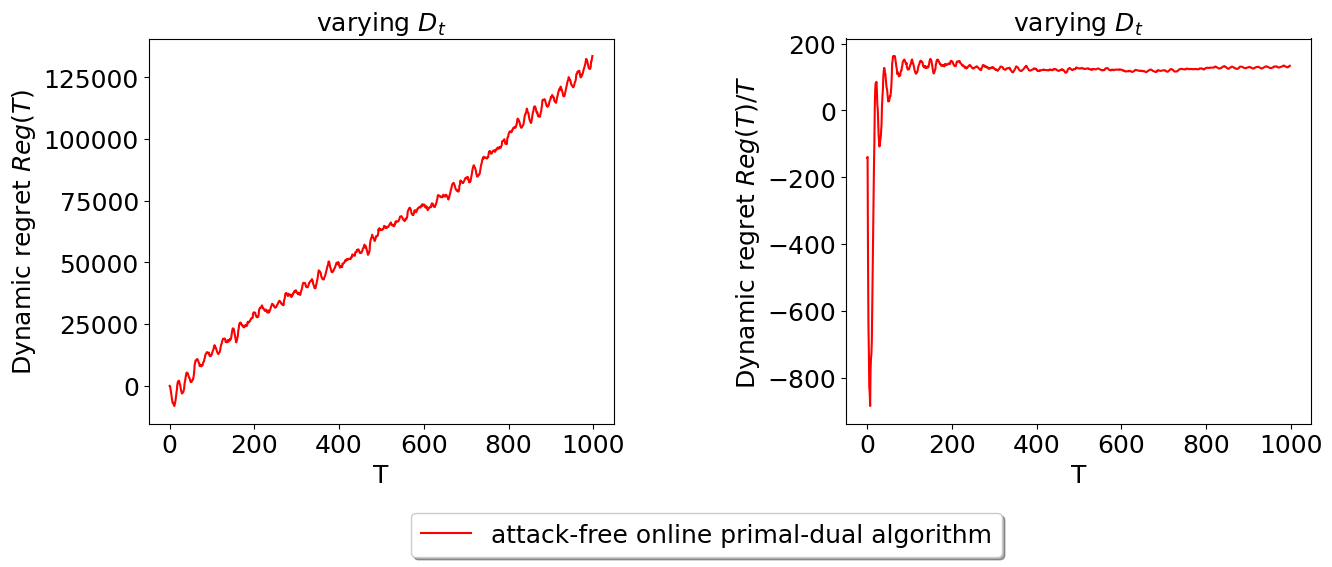

In [14]:
sub1=plt.subplot(1, 2, 1)##############################################################
iteration=[]
for i in range(0,999):
    iteration.append(i)

#在同一幅图片上画3条折线
A,=plt.plot(iteration,dynamic_regret,color = 'red',linewidth = '1.5',label='attack-free online primal-dual algorithm')


#设置图例并且设置图例的字体及大小
font1 = {
'size'   : 18,
}
#legend = plt.legend(handles=[A],prop=font1)
 
#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=18)
 
#设置横纵坐标的名称以及对应字体格式
font2 = {
'size'   : 18,
}
plt.xlabel('T',font2)
plt.ylabel(r'Dynamic regret $Reg(T)$',font2)
plt.title('varying $D_{t}$',font2) 

sub2=plt.subplot(1, 2, 2)##############################################################
iteration=[]
for i in range(0,999):
    iteration.append(i)

#在同一幅图片上画3条折线
A,=plt.plot(iteration,dynamic_regret_T,color = 'red',linewidth = '1.5',label='attack-free online primal-dual algorithm')


#设置图例并且设置图例的字体及大小
font1 = {
'size'   : 18,
}
#legend = plt.legend(handles=[A],prop=font1)
 
#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=18)
 
#设置横纵坐标的名称以及对应字体格式
font2 = {
'size'   : 18,
}
plt.xlabel('T',font2)
plt.ylabel(r'Dynamic regret $Reg(T)/T$',font2)
plt.title('varying $D_{t}$',font2) 

plt.legend(handles=[A],prop={'size':18},loc="upper center", bbox_to_anchor=[-0.3, -0.2],
           ncol=18, shadow=True, fancybox=True)

plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.gcf().set_size_inches((15, 5))

#plt.savefig('./figures/01-figure1_dynamic_regret_attack_free_varying_D.pdf',format='pdf', bbox_inches='tight')
#plt.savefig('./figures/01-figure1_dynamic_regret_attack_free_varying_D.png',format='png', bbox_inches='tight')

In [15]:
#累计的约束违反

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sympy import *
import math 
from datetime import datetime
from scipy.special import gamma, factorial
import scipy.special as sc

In [17]:
sum_thermal_wind_power_station_strategy=np.loadtxt("./data/02_IOS_optimal_parameters_large_Gaussian_Byzantine_attack_sum_thermal_wind_power_station_strategy.txt")
d_power_demand=np.loadtxt("./data/d_power_demand_normal_distribution_(70,5).txt")

In [18]:
accumulative_constraint_violation=[]
accumulative_constraint_violation_T=[]
for T in range(1, 1000):
    accumulative_constraint_violation_auxiliary_variable=0
    for t in range(0, T): 
        accumulative_constraint_violation_auxiliary_variable=accumulative_constraint_violation_auxiliary_variable+(1/5)*sum_thermal_wind_power_station_strategy[t+1]-d_power_demand[t+1]
    accumulative_constraint_violation.append(abs(accumulative_constraint_violation_auxiliary_variable))
    accumulative_constraint_violation_T.append(abs(accumulative_constraint_violation_auxiliary_variable)/T)

In [19]:
accumulative_constraint_violation

[6.505331695999999,
 29.963973501999995,
 60.71754176999999,
 93.916268022,
 125.83097055399999,
 155.92499927799997,
 183.06559964799996,
 196.66145446799993,
 209.25384550199993,
 230.60540947599995,
 240.14249790599996,
 228.77254868399996,
 216.79358304399994,
 202.21228508399992,
 176.7235745659999,
 154.6707391239999,
 139.6430867699999,
 127.7120600699999,
 109.9936289319999,
 105.9934466299999,
 109.6726533459999,
 117.16981617199991,
 131.60871125799991,
 153.7809627879999,
 165.5479908499999,
 190.74142596399992,
 216.0879015679999,
 228.41596422999987,
 240.2515750699999,
 240.68805384599986,
 235.28930939399984,
 239.81471242399982,
 231.8265853099998,
 221.1939443779998,
 201.2349776059998,
 185.3788712419998,
 172.8289817899998,
 145.4876400399998,
 132.9761619699998,
 131.3593366659998,
 133.23759091399978,
 150.22431879999976,
 164.17183152999976,
 177.79149446199978,
 193.42816497399977,
 206.80827241399976,
 223.61925871399976,
 237.06599020999974,
 254.31804062599974

In [20]:
#绘图 accumulative_constraint_violation和accumulative_constraint_violation_T

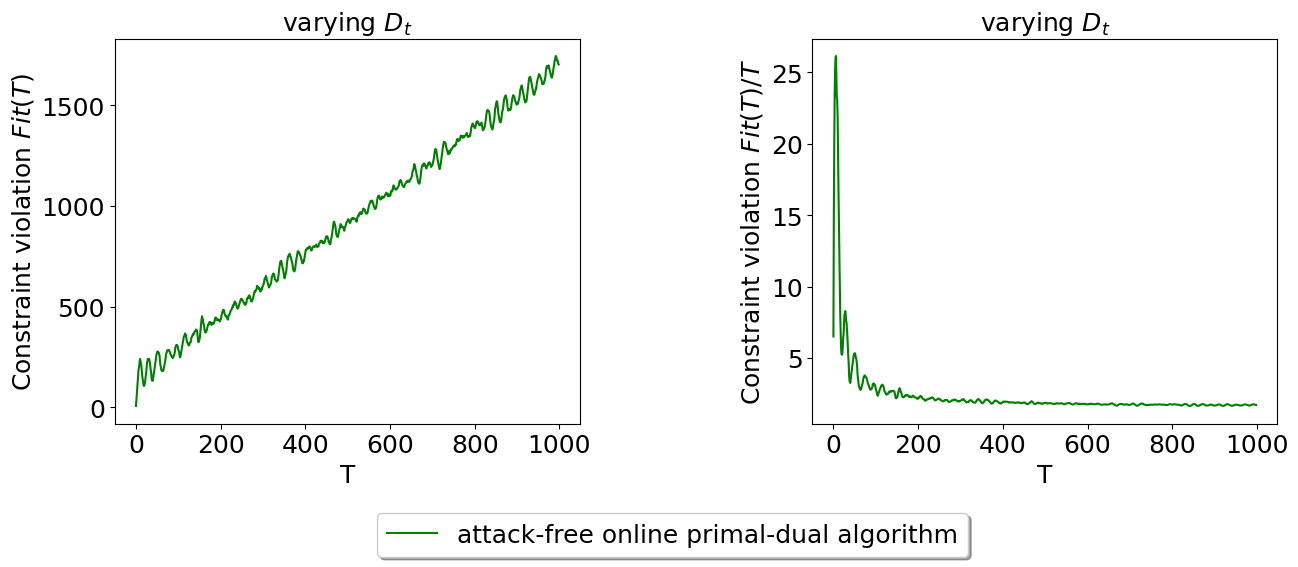

In [21]:
sub1=plt.subplot(1, 2, 1)##############################################################
iteration=[]
for i in range(0,999):
    iteration.append(i)

#在同一幅图片上画3条折线
A,=plt.plot(iteration,accumulative_constraint_violation,color = 'green',linewidth = '1.5',label='attack-free online primal-dual algorithm')


#设置图例并且设置图例的字体及大小
font1 = {
'size'   : 18,
}
#legend = plt.legend(handles=[A],prop=font1)
 
#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=18)
 
#设置横纵坐标的名称以及对应字体格式
font2 = {
'size'   : 18,
}
plt.xlabel('T',font2)
plt.ylabel(r'Constraint violation $Fit(T)$',font2)
plt.title('varying $D_{t}$',font2) 

sub2=plt.subplot(1, 2, 2)##############################################################
iteration=[]
for i in range(0,999):
    iteration.append(i)

#在同一幅图片上画3条折线
A,=plt.plot(iteration,accumulative_constraint_violation_T,color = 'green',linewidth = '1.5',label='attack-free online primal-dual algorithm')


#设置图例并且设置图例的字体及大小
font1 = {
'size'   : 18,
}
#legend = plt.legend(handles=[A],prop=font1)
 
#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=18)
 
#设置横纵坐标的名称以及对应字体格式
font2 = {
'size'   : 18,
}
plt.xlabel('T',font2)
plt.ylabel(r'Constraint violation $Fit(T)/T$',font2)
plt.title('varying $D_{t}$',font2) 

plt.legend(handles=[A],prop={'size':18},loc="upper center", bbox_to_anchor=[-0.3, -0.2],
           ncol=18, shadow=True, fancybox=True)

plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.gcf().set_size_inches((15, 5))


#plt.savefig('./figures/01-figure2_constraint_violation_attack_free_varying_D.pdf',format='pdf', bbox_inches='tight')
#plt.savefig('./figures/01-figure2_constraint_violation_attack_free_varying_D.png',format='png', bbox_inches='tight')